In [ ]:
!pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 KB 7.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import time
import string
import chart_studio.plotly
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import os

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
file_location = 'drive/MyDrive/train.csv'
df = pd.read_csv(file_location)
df.head()

,Unnamed: 0,Shuffled,Original,Target
0,0,سالگی پاریس ژانسم حومه در سن ۱ گذشت ۱ در ۱ در ...,مرگ ژانسم در ۱ اوت ۱ در سن ۱ سالگی در حومه پا...,"[14, 2, 4, 6, 13, 6, 4, 5, 6, 0, 4, 3, 1, 4, 7]"
1,1,غریب حاتم دارالعرب محمد میلادی اول قاهره چاپ و...,حاتم محمد بن غریب تاریخ عرب الهوله چاپ اول قاه...,"[1, 3, 10, 0, 15, 14, 12, 7, 5, 6, 2, 13, 8, 1..."
2,2,فرودگاهی کد ایالات کد فهرست متحده فرودگاهی یات...,کد فرودگاهی یاتا کد فرودگاهی ایکائو فهرست فرود...,"[1, 0, 7, 1, 0, 10, 4, 9, 2, 5, 8]"
3,3,وحدتیه طبیعت به است کوه‌های شهر برای زیبا مناس...,کوه‌های زیبا کوه‌های شهر وحدتیه به دلیل پدیده‌...,"[4, 7, 4, 5, 0, 2, 9, 10, 11, 8, 6, 1, 13, 3]"
4,4,سرباز در علاوه بر حادثه کشته این نیز دیگری گرد...,در این حادثه علاوه بر یک کشته سرباز دیگری نیز ...,"[1, 6, 4, 2, 3, 10, 5, 0, 8, 7, 11, 9]"


In [ ]:
original = df['Original']
shuffled = df['Shuffled']

In [ ]:
exclude = set(string.punctuation) # Set of all special characters
remove_digits = str.maketrans('', '', string.digits) # Set of all digits

In [ ]:
def preprocess_sentences(sent):
  wierd_pattern = re.compile("["
      u"\U0001F600-\U0001F64F"  # emojis
      u"\U0001F300-\U0001F5FF"  # symbols & pictographs
      u"\U0001F680-\U0001F6FF"  # transport & map symbols
      u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"
      u"\U0001f926-\U0001f937"
      u'\U00010000-\U0010ffff'
      u"\u200d"
      u"\u2640-\u2642"
      u"\u2600-\u2B55"
      u"\u23cf" #Unicode Character 'EJECT SYMBOL'
      u"\u23e9" #Unicode Character 'BLACK RIGHT-POINTING DOUBLE TRIANGLE'
      u"\u231a" #Unicode Character 'WATCH'
      u"\u3030" #Unicode Character 'WAVY DASH'
      u"\ufe0f" #Unicode VARIATION SELECTOR-16
      u"\u2069" #Unicode Character 'POP DIRECTIONAL ISOLATE'
      u"\u2066" #Unicode Character 'LEFT-TO-RIGHT ISOLATE'
      u"\u2068" #Unicode Character 'FIRST STRONG ISOLATE'
      u"\u2067" #Unicode Character 'RIGHT-TO-LEFT ISOLATE'
      "]+", flags=re.UNICODE)

  sent = wierd_pattern.sub(r'', sent)
  sent = re.sub("\u200c", " ", sent)
  sent = re.sub("'", '', sent)
  sent = ''.join(ch for ch in sent if ch not in exclude)
  sent = sent.translate(remove_digits)
  sent = sent.strip()
  sent = re.sub(" +", " ", sent)
  sent = '<شروع> ' + sent + ' <پایان>' # add <start> and <end> tokens
  return sent

In [ ]:
print(len(shuffled))
print(len(original))

1879299
1879299


In [ ]:
sent_pairs = []
for i in range(0,len(original)):
  sent_pair = []
  shuffled_sent = preprocess_sentences(shuffled[i])
  sent_pair.append(shuffled_sent)
  original_sent = preprocess_sentences(original[i])
  sent_pair.append(original_sent)
  if len(original_sent.split()) < 11 and len(shuffled_sent.split()) < 11:
    sent_pairs.append(sent_pair)

print(len(sent_pairs))

561671


In [ ]:
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<پد>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [ ]:
def max_length(tensor):
    return max(len(t) for t in tensor)

### Tokenization and Padding

In [ ]:
def load_dataset(pairs, num_examples):
    # pairs => already created cleaned input, output pairs
    # index language using the class defined above
    inp_lang = LanguageIndex(en for en, ma in pairs)
    targ_lang = LanguageIndex(ma for en, ma in pairs)
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, ma in pairs]
    target_tensor = [[targ_lang.word2idx[s] for s in ma.split(' ')] for en, ma in pairs]
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor,
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor,
                                                                  maxlen=max_length_tar,
                                                                  padding='post')
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [ ]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(sent_pairs, len(sent_pairs))

In [ ]:
input_tensor_train, input_tensor_tmp, target_tensor_train, target_tensor_tmp = train_test_split(input_tensor, target_tensor, test_size=0.05, random_state = 101)
input_tensor_val, input_tensor_test, target_tensor_val, target_tensor_test = train_test_split(input_tensor_tmp, target_tensor_tmp, test_size=0.1, random_state = 102)
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val),len(input_tensor_test), len(target_tensor_test)

(533587, 533587, 25275, 25275, 2809, 2809)

In [ ]:
BUFFER_SIZE_TRAIN = len(input_tensor_train)
BUFFER_SIZE_VAL = len(input_tensor_val)
BUFFER_SIZE_TEST = len(input_tensor_test)
BATCH_SIZE = 1024
dr = 0.33
N_BATCH_Train = BUFFER_SIZE_TRAIN//BATCH_SIZE
N_BATCH_Test = BUFFER_SIZE_TEST//BATCH_SIZE
embedding_dim = 256
units = 256
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset_train = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE_TRAIN)
dataset_train = dataset_train.batch(BATCH_SIZE, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE_VAL)
dataset_val = dataset_val.batch(BATCH_SIZE, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test))
dataset_test = dataset_test.batch(1, drop_remainder=True)

In [ ]:
def gru(units):

    return tf.keras.layers.GRU(units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_activation='sigmoid',
                                   recurrent_initializer='glorot_uniform')

The input to the encoder will be the Scrambled words and the output will be the hidden state and cell state of the GRU.

In [ ]:
import keras
from keras.layers import Dense, Flatten, Conv1D, BatchNormalization, Dropout, MaxPooling1D

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, batch_sz, dr, dec_units):
        super(Encoder, self).__init__()
        self.dec_units = dec_units
        self.batch_sz = batch_sz
        self.dr = dr
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.conv1 = Conv1D(filters = 512, kernel_size = 6, padding='same', activation='relu')
        self.conv2 = Conv1D(filters = 256, kernel_size = 6, padding='same', activation='relu')
        self.conv3 = Conv1D(filters = 128, kernel_size = 6, padding='same', activation='relu')
        self.pooling = MaxPooling1D(pool_size = 2)
        self.fc = Dense(self.dec_units, activation = 'linear')
        self.flatten = Flatten()
        self.batch_norm1 = BatchNormalization()
        self.batch_norm2 = BatchNormalization()
        self.batch_norm3 = BatchNormalization()
        self.dropout = Dropout(self.dr)

    def call(self, x):
        #print('x',x.shape)
        a = self.embedding(x)
        #print('a',a.shape)
        y = self.conv1(a)
        #print('y',y.shape)
        b = self.pooling(y)
        #print('b',b.shape)
        #c = self.batch_norm1(b)
        #print('c',c.shape)
        d = self.dropout(b)
        #print('d',d.shape)
        #########################
        z = self.conv2(d)
        #print('z',z.shape)
        e = self.pooling(z)
        #print('e',e.shape)
        #f = self.batch_norm2(e)
        #print('f',f.shape)
        g = self.dropout(e)
        #print('g',g.shape)
        #########################
        h = self.conv3(g)
        #print('h',h.shape)
        i = self.pooling(h)
        #print('i',i.shape)
        #j = self.batch_norm3(i)
        #print('j',j.shape)
        k = self.dropout(i)
        #print('k',k.shape)
        l = self.flatten(k)
        #print('l',l.shape)
        m = self.fc(l)
        #print('m',m.shape)
        return m

In [ ]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz, dr):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        self.dr = dr
        self.dropout = tf.keras.layers.Dropout(dr)

    def call(self, x, hidden):

        x = self.embedding(x)
        x = self.dropout(x)
        output, state = self.gru(x, initial_state = hidden)
        output, state = self.dropout(output), self.dropout(state)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        return self.dropout(x), self.dropout(state)

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [ ]:
encoder = Encoder(vocab_inp_size, embedding_dim, BATCH_SIZE, dr, units)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE, dr)

In [ ]:
optimizer = tf.optimizers.Adam()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [ ]:
checkpoint_dir = '/content/drive/MyDrive/'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training the Model

Epoch 1 Batch 0 Training Loss 6.8780
Epoch 1 Batch 100 Training Loss 3.2908
Epoch 1 Batch 200 Training Loss 2.8557
Epoch 1 Batch 300 Training Loss 2.6456
Epoch 1 Batch 400 Training Loss 2.3949
Epoch 1 Batch 500 Training Loss 2.1143
Epoch 1 Training Loss 2.8979
Epoch 1 Validation Loss 26.2264
Time taken for 1 epoch 2280.6460087299347 sec

Epoch 2 Batch 0 Training Loss 2.0867
Epoch 2 Batch 100 Training Loss 1.9781
Epoch 2 Batch 200 Training Loss 1.8666
Epoch 2 Batch 300 Training Loss 1.8789
Epoch 2 Batch 400 Training Loss 1.7312
Epoch 2 Batch 500 Training Loss 1.7052
Epoch 2 Training Loss 1.8864
Epoch 2 Validation Loss 19.9800
Time taken for 1 epoch 2275.0336282253265 sec

Epoch 3 Batch 0 Training Loss 1.5176
Epoch 3 Batch 100 Training Loss 1.5777
Epoch 3 Batch 200 Training Loss 1.4348
Epoch 3 Batch 300 Training Loss 1.3495
Epoch 3 Batch 400 Training Loss 1.3189
Epoch 3 Batch 500 Training Loss 1.3094
Epoch 3 Training Loss 1.4156
Epoch 3 Validation Loss 15.9880
Time taken for 1 epoch 2243

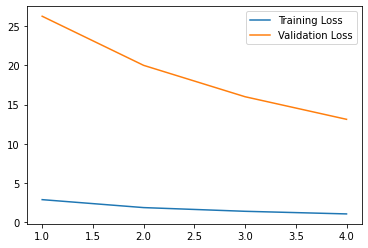

In [ ]:
import torch
EPOCHS = 4
m = torch.nn.Softmax(dim=1)
train_loss, test_loss = [], []

for epoch in range(EPOCHS):

    start = time.time()
    total_loss_train, total_loss_test = 0, 0

    for (batch, (inp, targ)) in enumerate(dataset_train):
        loss = 0

        with tf.GradientTape() as tape:
            enc_hidden = encoder(inp)
            dec_hidden = enc_hidden
            dec_input = tf.expand_dims([targ_lang.word2idx['<شروع>']] * BATCH_SIZE, 1)

            # Teacher forcing
            for t in range(1, targ.shape[1]):

                #predictions, dec_hidden ,_ = decoder(dec_input, dec_hidden, enc_output)
                predictions, dec_hidden = decoder(dec_input, dec_hidden)
                loss += loss_function(targ[:, t], predictions)
                # using teacher forcing
                #dec_input = tf.expand_dims(targ[:, t], 1)
                dec_input = tf.expand_dims(np.argmax(predictions, axis=-1), 1)

        batch_loss = (loss / int(targ.shape[1]))
        total_loss_train += batch_loss
        variables = encoder.variables + decoder.variables
        gradients = tape.gradient(loss, variables)
        optimizer.apply_gradients(zip(gradients, variables))

        if batch % 100 == 0:
            print('Epoch {} Batch {} Training Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving model every epoch
    checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Training Loss {:.4f}'.format(epoch + 1,
                                        total_loss_train / N_BATCH_Train))

    train_loss.append(total_loss_train/N_BATCH_Train)
###================================= Validation ==============================================================================
    for (batch, (inp, targ)) in enumerate(dataset_val):
      l = 0
      enc_hidden = encoder(inp)
      dec_hidden = enc_hidden
      dec_input = tf.expand_dims([targ_lang.word2idx['<شروع>']] * BATCH_SIZE, 1)

      for t in range(1, targ.shape[1]):
          #predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
          predictions, dec_hidden = decoder(dec_input, dec_hidden)
          l += loss_function(targ[:, t], predictions)
          dec_input = tf.expand_dims(np.argmax(predictions, axis=-1), 1)
      total_loss_test += (l / int(targ.shape[1])).numpy()
    test_loss.append(total_loss_test/N_BATCH_Test)
    print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1, total_loss_test / N_BATCH_Test))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

epochs = range(1,EPOCHS + 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, test_loss, label='Validation Loss')
plt.legend()
plt.show()

In [5]:
sent_gen_list = []
for (batch, (inp, targ)) in enumerate(dataset_test):

      enc_hidden = encoder(inp)
      dec_hidden = enc_hidden
      dec_input = tf.expand_dims([targ_lang.word2idx['<شروع>']] * 1, 1)
      words = targ[0].numpy()
      indexes = []
      temp_sent = ''
      temp_act = ''

      for j in range(0,10):
        if words[j] != 0 and words[j] != 2 and words[j] != 3:
          indexes.append(words[j])

      for t in range(0, len(words)):
          predictions, dec_hidden = decoder(dec_input, dec_hidden)
          res_list = [predictions[0][i].numpy() for i in indexes]
          dec_input = tf.convert_to_tensor([indexes[np.argmax(res_list)]])
          dec_input = tf.expand_dims(tf.convert_to_tensor(dec_input), 1,1)
          temp_sent += inp_lang.idx2word[indexes[np.argmax(res_list)]] + ' '
          indexes.remove(indexes[np.argmax(res_list)])
          if len(indexes) <= 0 :
            break
      sent_gen_list.append([temp_sent])

print(sent_gen_list[:2])

[['آریزونا در ۱ میلادی '], ['آتش بازی روی برج ایفل در جشن باستیل ']]


In [4]:
sent_act_list = []
for (batch, (inp, targ)) in enumerate(dataset_test):
  tmp = targ[0].numpy()
  tmp2 = []
  sent = ''

  for j in range(0,10):
    if tmp[j] != 2 and tmp[j] != 0 and tmp[j] != 3:
      tmp2.append(tmp[j])
  for k in range(0,len(tmp2)):
    sent += inp_lang.idx2word[tmp2[k]] + ' '
  sent_act_list.append([sent])

print(sent_act_list[:2])

[['آریزونا در ۱ میلادی '], ['آتش بازی روی برج ایفل در جشن باستیل ']]


In [10]:
from nltk.translate.bleu_score import sentence_bleu

score_list = []
for i in range(0,len(sent_act_list)):
  score_list.append(sentence_bleu(sent_act_list[i], sent_gen_list[i], weights=(0.25, 0.25, 0.25, 0.25)))

print('bleu total is: {:.2f}'.format(np.mean(score_list)))

bleu total is: 0.27
